In [1]:
import os
import json
import numpy as np
import io
from datetime import datetime
from data_generator import DataGenerator
from trade_env import TraderEnv
from rnn.model_keras import NeuralNetwork
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from sklearn.preprocessing import MinMaxScaler

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

#for logging
import time

import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline

/Users/samirantonio/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/Users/samirantonio/anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
dt = DataGenerator(random=False, first_index=10)
dt.rewind()

In [3]:
last_price = 0
last_time = 0
steps = 5000
def get_state(raw_state):
    global last_price
    global last_time
    list = []

    price = raw_state["price"]

    def prepare_orders(orders, price, multi):
        amount = float(orders[0][1])
        for order in orders:
            list.append((float(order[0])/price) * multi)
            #list.append(float(order[1])/amount)

    bids = raw_state["bids"][:5]
    asks = raw_state["asks"][:5]
    prepare_orders(bids, price, 1)
    prepare_orders(asks, price, -1)


    if last_price != 0:
        list.extend([price])
    else:
        list.extend([0])
        
    
    if last_time != 0:
        list.extend([int(state['timestamp'])/last_time])
    else:
        list.extend([0])
        
    last_time = int(state['timestamp'])
    last_price = price
    
    y = dt.get_from_index(dt.index + steps)["price"]
    
    if y > price:
        y = onehot_encoded(0)
    elif y < price: 
        y = onehot_encoded(2)
    else:
        y = onehot_encoded(1)
        
    data = time.ctime(int(state['timestamp']))
    
    list.extend(y)
    
    #list[0] = data
    #list[-1] = data
    
    #return [list, y]
    return price


In [4]:
# integer encode input data
def onehot_encoded (integer_encoded, char_to_int = 3):
    # one hot encode
    onehot_encoded = list()
    letter = [0 for _ in range(char_to_int)]
    letter[integer_encoded] = 1
    onehot_encoded.append(letter)
    
    return onehot_encoded[0]

In [5]:
def load_data(data, sequence_length):
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #Normalizing data by going through each window
    #Every value in the window is divided by the first value in the window, and then 1 is subtracted
    dr = np.array(result)
    #print(d0.shape)
    #dr = np.zeros_like(d0)
    #dr[:,1:,:] = d0[:,1:,:] / d0[:,0:1,:] - 1
    
    #Splitting data set into training (First 90% of data points) and testing data (last 10% of data points)
    split_line = round(0.9 * dr.shape[0])
    training_data = dr[:int(split_line), :]
    
    #Shuffle the data
    np.random.shuffle(training_data)
    
    #Training Data
    X_train = training_data[:,:-1,:-3]
    
    #X_train = X_train[:,:,:] / X_train[:,0:1,:] - 1
    
    Y_train = training_data[:,-2,-3:]
    
    window_size = sequence_length - 1
    
    print (X_train.shape)
    print (Y_train.shape)
    
    return X_train, Y_train, window_size #, X_test, Y_test#, Y_daybefore, unnormalized_bases, window_size

In [6]:
data = []
count = 0
while len(data) < 5000: #(dt.max_steps() - steps*3):
    state = dt.next()
    state = get_state(state)
    data.append(state)
dt.rewind()

In [7]:
sequence_length = 500

In [8]:
X_train, Y_train, window_size = load_data(data, sequence_length)

IndexError: too many indices for array

In [ ]:
batch = 13
#print (X_train[batch,:,0])

In [ ]:
print (Y_train[batch, 2])

In [ ]:
def initialize_model(window_size, dropout_value, activation_function, loss_function, optimizer):

    #Create a Sequential model using Keras
    model = Sequential()

    #First recurrent layer with dropout
    model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
    model.add(Dropout(dropout_value))

    #Second recurrent layer with dropout
    #model.add(Bidirectional(LSTM((window_size), return_sequences=True)))
    #model.add(Dropout(dropout_value))

    #Third recurrent layer
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    #Output layer (returns the predicted value)
    model.add(Dense(units=3))
    
    #Set activation function
    model.add(Activation(activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae', 'acc'])
    
    return model

In [ ]:
def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2400, 49, 35) that represents the x values of the training data
    Y_train -- A tensor of shape (2400,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 1024
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
    #Record the time the model starts training
    start = time.time()

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, epochs=num_epoch, validation_split= val_split)

    #Get the time it took to train the model (in seconds)
    training_time = int(math.floor(time.time() - start))
    return model, training_time

In [ ]:
model = initialize_model(window_size, 0.2, 'softmax', 'mse', 'adam')
#print (model.summary())

In [ ]:
epochs = 100
model, training_time = fit_model(model, X_train, Y_train, 1024, epochs, .05)

#Print the training time
#print ("Training time", training_time, "seconds")

In [ ]:
xdata = X_train
y_train_reshaped = Y_train
nn = NeuralNetwork(0.00001, xdata.shape[2], y_train_reshaped.shape[1], xdata.shape[1])

In [ ]:
nn.train(xdata, y_train_reshaped, epochs, .5)

In [ ]:
training_data = np.arange(20)

In [ ]:
pylab.rcParams['figure.figsize'] = (15, 10)   # Change the size of plots
pylab.plot(data) 

In [9]:
data[0]

17605.73

In [10]:
result = []
sequence_length = 30
for index in range(len(data) - sequence_length):
    tmp = data[index: index + sequence_length]
    result.append(sum(tmp) / float(len(tmp)))

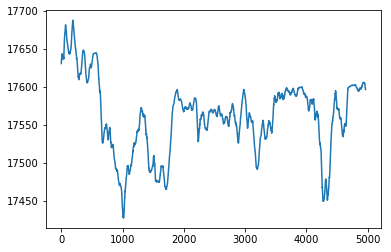

In [11]:
pylab.plot(result) 

In [14]:
from scipy import signal
import numpy as np

max_peak_width = 15

#inverted = 1./np.array(y_coordinates)

y_coordinates = result
peak_widths = np.arange(3, max_peak_width)
peak_indices = signal.find_peaks_cwt(y_coordinates, np.arange(19,20))
peak_count = len(peak_indices) # the number of peaks in the array

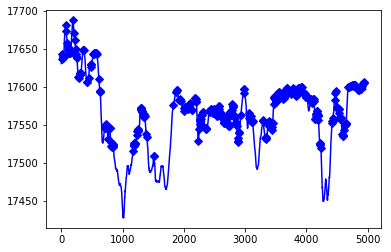

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import peakutils

markers_on = peak_indices
plt.plot(arange(len(result)), result,'-bD', markevery = markers_on.tolist())
plt.show()